In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
sequence_length = 4
batch_size = 1
input_dim = 512 # features for every word
d_model = 512 # output of attention model for every word
x = torch.randn((batch_size, sequence_length, input_dim))


In [3]:
x.size()

torch.Size([1, 4, 512])

In [4]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)

In [5]:
qkv = qkv_layer(x)

In [6]:
qkv.shape

torch.Size([1, 4, 1536])

Matplotlib is building the font cache; this may take a moment.


Text(0.5, 1.0, 'qkv distribution')

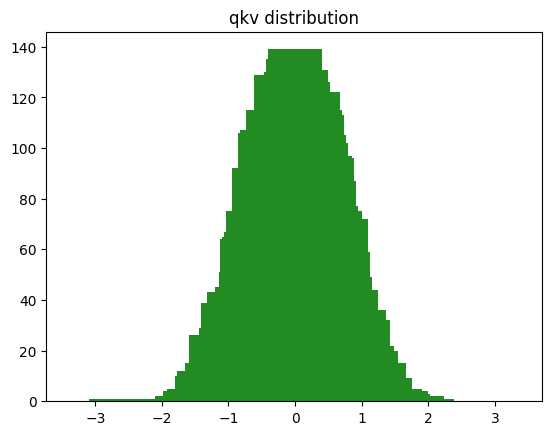

In [9]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins = 200, min =-3, max = 3)
x_val = np.arange(-1,1,0.01)*3
plt.bar(x_val,y_val,align='center', color='forestgreen')
plt.title('qkv distribution')

In [10]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3*head_dim)

In [11]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [12]:
qkv = qkv.permute(0,2,1,3) # [batch_size, num_heads, seq_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [13]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [14]:
import math
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2,-1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [15]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal =1)
mask[0][1] # mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [16]:
mask.shape

torch.Size([1, 8, 4, 4])

In [17]:
scaled += mask
scaled[0][0]

tensor([[ 0.3613,    -inf,    -inf,    -inf],
        [-0.1416,  0.1418,    -inf,    -inf],
        [ 0.3297, -0.1703, -0.3739,    -inf],
        [ 0.1691, -0.5189, -0.3019,  0.2752]], grad_fn=<SelectBackward0>)

In [19]:
attention = F.softmax(scaled, dim = -1)
attention.shape, attention[0][0]

(torch.Size([1, 8, 4, 4]),
 tensor([[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4296, 0.5704, 0.0000, 0.0000],
         [0.4759, 0.2887, 0.2355, 0.0000],
         [0.3088, 0.1552, 0.1928, 0.3433]], grad_fn=<SelectBackward0>))

In [20]:
values = attention @ v
values.shape

torch.Size([1, 8, 4, 64])

Functions

In [21]:
import math

def scaled_dot_product(q,k,v,mask=None):
    d_k = q.size()[-1]
    scaled = (q @ k.transpose(-2,-1)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim =-1)
    values = attention @ v
    return values, attention

In [23]:
values, attention = scaled_dot_product(q,k,v,mask=mask)
attention.shape, attention[0][0]

(torch.Size([1, 8, 4, 4]),
 tensor([[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4296, 0.5704, 0.0000, 0.0000],
         [0.4759, 0.2887, 0.2355, 0.0000],
         [0.3088, 0.1552, 0.1928, 0.3433]], grad_fn=<SelectBackward0>))

In [24]:
values.size()

torch.Size([1, 8, 4, 64])

In [25]:
# concat the heads
values = values.reshape(batch_size, sequence_length, num_heads*head_dim)
values.size()

torch.Size([1, 4, 512])

In [26]:
linear_layer = nn.Linear(d_model, d_model)
out = linear_layer(values)
out.shape

torch.Size([1, 4, 512])

# Put Everything Together!!

B-> batch size; T-> seq length; head dim -> d_model/n_heads; n_embed = d_model = num_heads * head_dim
- Get x -> token embedding + positional embedding -> [B, T, n_embed]
- Get qkv -> linear layer(n_embed, 3 * d_model (attention model out size))
- Pass x to qkv layer -> [B, T, 3 * d_model]
- Break qkv to split it across all heads -> [B, T, num_heads, 3 * head dim]
- Permute [B, T, num_heads, 3 * head dim] -> [B, num_heads, T, 3 * head dim]
- Split q,k,v -> [B, num_heads, T, head_dim]
- Scaled dot prod attention:
    - values -> [B, num_heads, T, head_dim]
    - attention -> [B, num_heads, T, T]
- Concatenate heads in value -> [B, T, num_heads * head_dim]
- Output linear layer -> [B, T, num_heads * head_dim]

In [27]:
import math
import torch.nn as nn
import torch

def scaled_dot_product(q,k,v,mask=None):
    d_k = q.size()[-1]
    scaled = (q @ k.transpose(-2,-1)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim =-1)
    values = attention @ v
    return values, attention

In [28]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim, 3*d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"{x.size()= }")
        qkv = self.qkv_layer(x)
        print(f"{qkv.size()= }")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3*self.head_dim)
        print(f"{qkv.size()= }")
        qkv = qkv.permute(0,2,1,3)
        print(f"{qkv.size()= }")
        q, k, v = qkv.chunk(3, dim =-1)
        print(f"{q.size()= } {k.size()= } {v.size()= }")
        values,attention = scaled_dot_product(q,k,v,mask)
        print(f"{values.size()= } {attention.size()= }")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"{values.size()= }")
        out = self.linear_layer(values)
        print(f"{out.size()= }")
        return out

In [29]:
input_dim = 1024
d_model = 512
num_heads = 8
batch_size = 30
sequence_length = 5
x = torch.randn((batch_size, sequence_length, input_dim))
model = MultiHeadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size()= torch.Size([30, 5, 1024])
qkv.size()= torch.Size([30, 5, 1536])
qkv.size()= torch.Size([30, 5, 8, 192])
qkv.size()= torch.Size([30, 8, 5, 192])
q.size()= torch.Size([30, 8, 5, 64]) k.size()= torch.Size([30, 8, 5, 64]) v.size()= torch.Size([30, 8, 5, 64])
values.size()= torch.Size([30, 8, 5, 64]) attention.size()= torch.Size([30, 8, 5, 5])
values.size()= torch.Size([30, 5, 512])
out.size()= torch.Size([30, 5, 512])
